In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import STAT5102_2023 as stat


In [2]:
# Connect to the SQLite database
con = sqlite3.connect("Topic1_dataset.sqlite")

# Create a cursor to execute SQL commands
cur = con.cursor()

In [3]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
tables

[('sqlite_sequence',), ('products',), ('purchase',), ('sales',), ('shops',)]

In [4]:
def get_pd_dataframe(query, connection):
    return pd.read_sql_query(query, connection)

products_preview = get_pd_dataframe("SELECT * FROM products ;", con)

purchase_preview = get_pd_dataframe("SELECT * FROM purchase ;", con)

shops_preview = get_pd_dataframe("SELECT * FROM shops;", con)

sales_preview = get_pd_dataframe("SELECT * FROM sales;", con)


In [6]:
zeroprice = products_preview[products_preview['price']== 0]
zeroprice


,product,title,price,book_original_price,barcode,barcode2,isbn
1710,9781546176183,DOG MAN #14: Big Jim Believes,0.000000,159.90,9781546176183,9781546176183,9781546176183
2302,PREORDER,Pre-order: Dog Man #9 Crime and Punishment (97...,0.000000,None,000640,000640,SPECIAL PRICE
2303,PREORDER-01,Pre-order: 130 Storey Treehouse (9781529017922),0.000000,89.00,None,000719,None
2304,PREORDER-03,Pre-order: Dog Man #10 Mothering Heights (9781...,0.000000,None,000728,000728,None


In [7]:
# Find rows where barcode2 is duplicated
duplicates = products_preview[products_preview['barcode2'].duplicated(keep=False)]

# Display all columns for these rows
duplicates


,product,title,price,book_original_price,barcode,barcode2,isbn
530,1419101114,Paw Prints B.Bks: Numbers,9.900000,9.90,9781419101113,786943084221,None
531,1419101122,Paw Prints B.Bks: Best Friends,9.900000,9.90,9781419101120,786943084221,None
532,1419101130,Paw Prints B.Bks: Colors,9.900000,9.90,9781419101137,786943084221,None
533,1419402161,All About Me! Foam Bk: S.St. - Big Bird,35.000000,35.00,9781419402166,786943086102,None
534,141940217X,All About Me! Foam Bk: S.St. - Cookie Monster,35.000000,35.00,9781419402173,786943086102,None
535,1419402188,All About Me! Foam Bk: S.St. - Elmo,35.000000,35.00,9781419402180,786943086102,None
694,1576571742,Super Chunky! First Words B.Bks: ABC,9.900000,9.90,9781576571743,786943004793,None
695,1576571750,Super Chunky! First Words B.Bks: Helping Hands,9.900000,9.90,9781576571750,786943004793,None
696,1576571769,Super Chunky! First Words B.Bks: Welcome to My...,9.900000,9.90,9781576571767,786943004793,None
697,1576571777,"Super Chunky! First Words B.Bks: Beep, Vroom, ...",9.900000,9.90,9781576571774,786943004793,None


In [8]:
# Merge sales_preview with shops_preview and products_preview
merged_df = sales_preview.merge(shops_preview[['location', 'shopname']], on='location', how='left')
merged_df = merged_df.merge(products_preview[['product', 'title', 'price','barcode2']].rename(columns={'price': 'market_price'}), on='product', how='left')

In [9]:
# Calculate final price
merged_df['final_price']= merged_df['amount'] / merged_df['quantity']

In [10]:
# Calculate final discount percentage
merged_df['final_discount'] = (merged_df['market_price'] - merged_df['final_price'] ) / merged_df['market_price'] * 100

In [11]:
# Change channel to 'Bookfair - Roadshow' if client name is 'Hong Kong Book Fair'
merged_df.loc[merged_df['clients'] == 'Hong Kong Book Fair', 'channel'] = 'Bookfair - Roadshow'

# Verify the update
print(merged_df[merged_df['clients'] == 'Hong Kong Book Fair'][['clients', 'channel']].head())

                   clients              channel
47833  Hong Kong Book Fair  Bookfair - Roadshow
47834  Hong Kong Book Fair  Bookfair - Roadshow
47835  Hong Kong Book Fair  Bookfair - Roadshow
47836  Hong Kong Book Fair  Bookfair - Roadshow
47837  Hong Kong Book Fair  Bookfair - Roadshow


In [12]:
# Remove rows where price <= 0
merged_df = merged_df[merged_df['market_price'] > 0]


In [13]:
#merged_df['First_sale'] = merged_df.groupby('product')['trandate'].transform('min')

In [14]:
# Split the merged_df into two DataFrames based on channel
merged_retail_df = merged_df[merged_df['channel'] == 'Retail']
merged_roadshow_df = merged_df[merged_df['channel'] == 'Bookfair - Roadshow']

In [15]:
# Calculate the first sale date for each product
#merged_retail_df['First_sale'] = merged_retail_df.groupby('product')['trandate'].transform('min')
#merged_roadshow_df['First_sale'] = merged_roadshow_df.groupby('product')['trandate'].transform('min')


In [16]:

import pandas as pd

def expand_quarterly_sales(df: pd.DataFrame, output_filename: str = None) -> pd.DataFrame:
    """
    Expand quarterly sales data for each product, including projections and quarters since first sale.
    Adds a flag column for specific book titles.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns ['barcode2', 'trandate', 'quantity', 'final_discount', 'title'].
        output_filename (str, optional): If provided, the expanded DataFrame will be exported to this CSV file.

    Returns:
        pd.DataFrame: Expanded quarterly summary DataFrame.
    """
    # Ensure datetime and quarter columns
    df['trandate'] = pd.to_datetime(df['trandate'])
    df['year_quarter'] = df['trandate'].dt.to_period('Q')

    expanded_rows = []

    for product, group in df.groupby('barcode2'):
        first_sale_date = group['trandate'].min()
        quarterly_sales = group.groupby('year_quarter')['quantity'].sum()
        quarterly_discount = group.groupby('year_quarter')['final_discount'].mean()

        # Full range of quarters from first to last
        start_q = quarterly_sales.index.min()
        end_q = quarterly_sales.index.max()
        full_quarters = pd.period_range(start=start_q, end=end_q, freq='Q')

        # Reindex to include missing quarters
        quarterly_sales = quarterly_sales.reindex(full_quarters, fill_value=0)
        quarterly_discount = quarterly_discount.reindex(full_quarters)

        first_q = full_quarters[0]  # First sale quarter

        # Get book title for this product
        book_title = group['title'].iloc[0] if 'title' in group.columns else ''

        # Check if title matches any keyword
        keywords = ['Guinness World', 'Dog Man', 'Cat Kid', 'Captain Underpants', 'Andy Griffiths']
        book_flag = 1 if any(keyword.lower() in str(book_title).lower() for keyword in keywords) else 0

        for idx, current_q in enumerate(full_quarters):
            prev_qty = quarterly_sales.iloc[idx - 1] if idx > 0 else 0
            curr_qty = quarterly_sales.iloc[idx]
            avg_discount = quarterly_discount.iloc[idx]

            quarter_num = current_q.quarter

            # How many quarters after first sale
            quarters_since_first = (current_q - first_q).n  # difference in quarters

            # Projections: next 4 quarters after current_q
            projections = []
            for i in range(1, 5):
                next_q = current_q + i
                projections.append(quarterly_sales.get(next_q, pd.NA))

            expanded_rows.append({
                'barcode2': product,
                'Current_quarter': str(current_q),
                'Quarter_num': quarter_num,
                'Quarters_since_first': quarters_since_first,
                'Previous_quarter_qty': prev_qty,
                'Current_quarter_qty': curr_qty,
                'Avg_discount': avg_discount,
                'First_day': first_sale_date,
                'Next_Q1': projections[0],
                'Next_Q2': projections[1],
                'Next_Q3': projections[2],
                'Next_Q4': projections[3],
                'Book_Flag': book_flag
            })

    quarter_expanded_df = pd.DataFrame(expanded_rows)

    # ✅ Cleaning Step: Replace NaN with 0 and convert Next_Q columns to int
    cols_to_update = ['Avg_discount', 'Next_Q1', 'Next_Q2', 'Next_Q3', 'Next_Q4']
    quarter_expanded_df[cols_to_update] = quarter_expanded_df[cols_to_update].fillna(0)

    # Convert Next_Q columns to integers
    quarter_expanded_df[['Next_Q1', 'Next_Q2', 'Next_Q3', 'Next_Q4']] = \
        quarter_expanded_df[['Next_Q1', 'Next_Q2', 'Next_Q3', 'Next_Q4']].astype(int)

    # Export if filename provided
    if output_filename:
        quarter_expanded_df.to_csv(output_filename, index=False)
        print(f"Exported to {output_filename}")

    return quarter_expanded_df


In [17]:
expand_quarterly_sales_retail_df = expand_quarterly_sales(merged_retail_df, output_filename="expand_quarterly_sales_retail.csv")
expand_quarterly_sales_roadshow_df = expand_quarterly_sales(merged_roadshow_df, output_filename="expand_quarterly_sales_roadshow.csv")


# Add a new column 'channel': retail = 0, roadshow = 1
expand_quarterly_sales_retail_df['channel'] = 0
expand_quarterly_sales_roadshow_df['channel'] = 1

# Combine the two DataFrames
expand_quarterly_sales_combined_df = pd.concat([expand_quarterly_sales_retail_df, expand_quarterly_sales_roadshow_df], ignore_index=True)

cols = ['channel'] + [col for col in expand_quarterly_sales_combined_df.columns if col != 'channel']
expand_quarterly_sales_combined_df = expand_quarterly_sales_combined_df[cols]


# Save the combined DataFrame to a new CSV file
output_file = "expand_quarterly_sales_combined_df.csv"
expand_quarterly_sales_combined_df.to_csv(output_file, index=False)

# Print confirmation and basic info
print(f"Combined file saved as {output_file}.")


Exported to expand_quarterly_sales_retail.csv
Exported to expand_quarterly_sales_roadshow.csv
Combined file saved as expand_quarterly_sales_combined_df.csv.


In [20]:
#Sample Checking for Guinness World Records 2024,9781913484385
expand_quarterly_sales_retail_df[expand_quarterly_sales_retail_df['barcode2'] == '9781913484385']

,barcode2,Current_quarter,Quarter_num,Quarters_since_first,Previous_quarter_qty,Current_quarter_qty,Avg_discount,First_day,Next_Q1,Next_Q2,Next_Q3,Next_Q4,Book_Flag,channel
48033,9781913484385,2023Q4,4,0,0,171,0.601308,2023-10-19,77,32,1,0,1,0
48034,9781913484385,2024Q1,1,1,171,77,9.936967,2023-10-19,32,1,0,0,1,0
48035,9781913484385,2024Q2,2,2,77,32,13.125000,2023-10-19,1,0,0,0,1,0
48036,9781913484385,2024Q3,3,3,32,1,0.000000,2023-10-19,0,0,0,0,1,0


In [21]:
expand_quarterly_sales_roadshow_df[expand_quarterly_sales_roadshow_df['barcode2'] == '9781913484385']

,barcode2,Current_quarter,Quarter_num,Quarters_since_first,Previous_quarter_qty,Current_quarter_qty,Avg_discount,First_day,Next_Q1,Next_Q2,Next_Q3,Next_Q4,Book_Flag,channel
17391,9781913484385,2023Q4,4,0,0,1,-28.870293,2023-12-17,0,0,0,0,1,1


In [22]:
#Sample Checking for Dav Pilkey - Cat Kid Comic Club #1, 978981495800
expand_quarterly_sales_combined_df[expand_quarterly_sales_combined_df['barcode2'] == '978981495800']

,channel,barcode2,Current_quarter,Quarter_num,Quarters_since_first,Previous_quarter_qty,Current_quarter_qty,Avg_discount,First_day,Next_Q1,Next_Q2,Next_Q3,Next_Q4,Book_Flag
52040,0,978981495800,2022Q1,1,0,0,3,20.022247,2022-03-30,46,47,26,0,1
52041,0,978981495800,2022Q2,2,1,3,46,8.076607,2022-03-30,47,26,0,15,1
52042,0,978981495800,2022Q3,3,2,46,47,2.130026,2022-03-30,26,0,15,19,1
52043,0,978981495800,2022Q4,4,3,47,26,6.738256,2022-03-30,0,15,19,8,1
52044,0,978981495800,2023Q1,1,4,26,0,0.000000,2022-03-30,15,19,8,5,1
52045,0,978981495800,2023Q2,2,5,0,15,1.334816,2022-03-30,19,8,5,13,1
52046,0,978981495800,2023Q3,3,6,15,19,0.526901,2022-03-30,8,5,13,17,1
52047,0,978981495800,2023Q4,4,7,19,8,0.000000,2022-03-30,5,13,17,9,1
52048,0,978981495800,2024Q1,1,8,8,5,0.000000,2022-03-30,13,17,9,0,1
52049,0,978981495800,2024Q2,2,9,5,13,0.000000,2022-03-30,17,9,0,1,1


In [23]:
#Sample Checking for Dav Pilkey - Cat Kid Comic Club #1, 978981495800
expand_quarterly_sales_retail_df[expand_quarterly_sales_retail_df['barcode2'] == '978981495800']

,barcode2,Current_quarter,Quarter_num,Quarters_since_first,Previous_quarter_qty,Current_quarter_qty,Avg_discount,First_day,Next_Q1,Next_Q2,Next_Q3,Next_Q4,Book_Flag,channel
52040,978981495800,2022Q1,1,0,0,3,20.022247,2022-03-30,46,47,26,0,1,0
52041,978981495800,2022Q2,2,1,3,46,8.076607,2022-03-30,47,26,0,15,1,0
52042,978981495800,2022Q3,3,2,46,47,2.130026,2022-03-30,26,0,15,19,1,0
52043,978981495800,2022Q4,4,3,47,26,6.738256,2022-03-30,0,15,19,8,1,0
52044,978981495800,2023Q1,1,4,26,0,0.000000,2022-03-30,15,19,8,5,1,0
52045,978981495800,2023Q2,2,5,0,15,1.334816,2022-03-30,19,8,5,13,1,0
52046,978981495800,2023Q3,3,6,15,19,0.526901,2022-03-30,8,5,13,17,1,0
52047,978981495800,2023Q4,4,7,19,8,0.000000,2022-03-30,5,13,17,9,1,0
52048,978981495800,2024Q1,1,8,8,5,0.000000,2022-03-30,13,17,9,0,1,0
52049,978981495800,2024Q2,2,9,5,13,0.000000,2022-03-30,17,9,0,1,1,0


In [24]:
expand_quarterly_sales_roadshow_df[expand_quarterly_sales_roadshow_df['barcode2'] == '978981495800']

,barcode2,Current_quarter,Quarter_num,Quarters_since_first,Previous_quarter_qty,Current_quarter_qty,Avg_discount,First_day,Next_Q1,Next_Q2,Next_Q3,Next_Q4,Book_Flag,channel
20126,978981495800,2022Q3,3,0,0,113,28.309232,2022-07-26,0,0,0,91,1,1
20127,978981495800,2022Q4,4,1,113,0,0.000000,2022-07-26,0,0,91,0,1,1
20128,978981495800,2023Q1,1,2,0,0,0.000000,2022-07-26,0,91,0,0,1,1
20129,978981495800,2023Q2,2,3,0,0,0.000000,2022-07-26,91,0,0,0,1,1
20130,978981495800,2023Q3,3,4,0,91,45.494994,2022-07-26,0,0,0,111,1,1
20131,978981495800,2023Q4,4,5,91,0,0.000000,2022-07-26,0,0,111,0,1,1
20132,978981495800,2024Q1,1,6,0,0,0.000000,2022-07-26,0,111,0,0,1,1
20133,978981495800,2024Q2,2,7,0,0,0.000000,2022-07-26,111,0,0,0,1,1
20134,978981495800,2024Q3,3,8,0,111,45.071291,2022-07-26,0,0,0,0,1,1


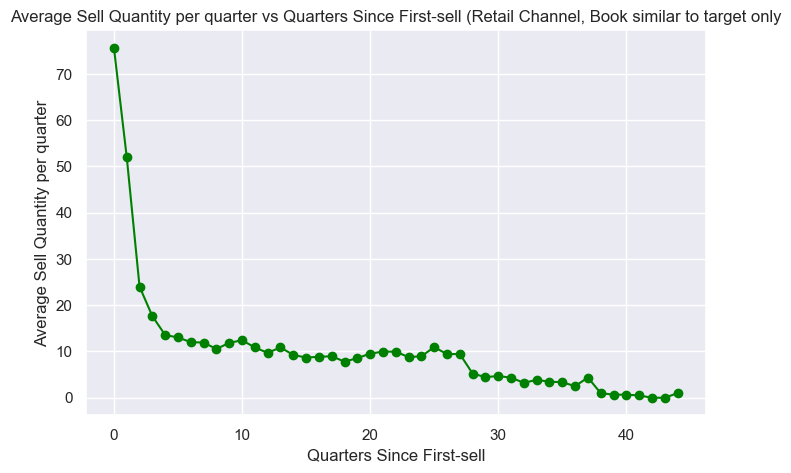

In [25]:

import pandas as pd
import matplotlib.pyplot as plt

# Filter rows where Book_Flag == 1
expand_quarterly_sales_retail_target_df = expand_quarterly_sales_retail_df[expand_quarterly_sales_retail_df['Book_Flag'] == 1]

# Compute average quantity per quarter
avg_df = expand_quarterly_sales_retail_target_df.groupby('Quarters_since_first')['Current_quarter_qty'].mean().reset_index()

# Plot the average values
plt.figure(figsize=(8, 5))
plt.plot(avg_df['Quarters_since_first'], avg_df['Current_quarter_qty'], marker='o', linestyle='-', color='green')

# Add labels and title
plt.title('Average Sell Quantity per quarter vs Quarters Since First-sell (Retail Channel, Book similar to target only')
plt.xlabel('Quarters Since First-sell')
plt.ylabel('Average Sell Quantity per quarter')

# Add grid
plt.grid(True)


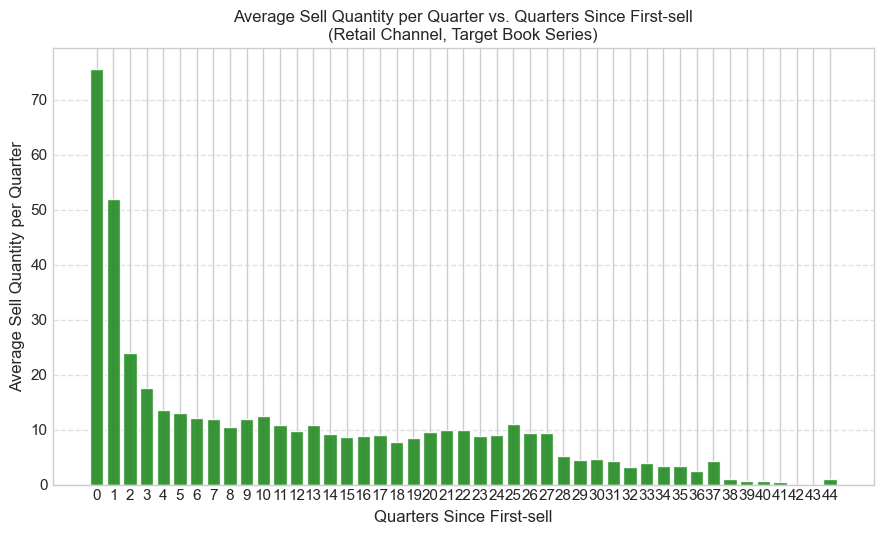

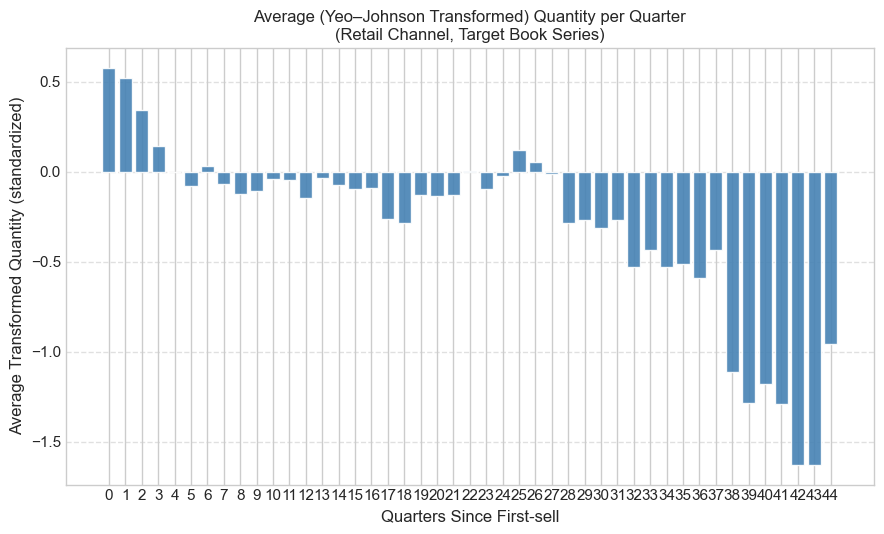

In [52]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# --- 0) Style (optional) ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- 1) Filter rows where Book_Flag == 1 ---
expand_quarterly_sales_retail_target_df = expand_quarterly_sales_retail_df[
    expand_quarterly_sales_retail_df['Book_Flag'] == 1
].copy()

# --- 2) Ensure numeric & drop NaNs for the quantity and quarter fields ---
expand_quarterly_sales_retail_target_df['Current_quarter_qty'] = pd.to_numeric(
    expand_quarterly_sales_retail_target_df['Current_quarter_qty'], errors='coerce'
)
expand_quarterly_sales_retail_target_df = expand_quarterly_sales_retail_target_df.dropna(
    subset=['Current_quarter_qty', 'Quarters_since_first']
)

# --- 3) Apply Yeo-Johnson transformation (works with positives & negatives) ---
pt_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
y_transformed = pt_scaler.fit_transform(
    expand_quarterly_sales_retail_target_df['Current_quarter_qty'].to_numpy().reshape(-1, 1)
)
expand_quarterly_sales_retail_target_df['quantity_transformed'] = y_transformed

# --- 4A) Compute average ORIGINAL quantity per quarter ---
avg_orig = (
    expand_quarterly_sales_retail_target_df
    .groupby('Quarters_since_first')['Current_quarter_qty']
    .mean()
    .reset_index()
    .sort_values('Quarters_since_first')
)

# --- 4B) Compute average TRANSFORMED quantity per quarter ---
avg_trans = (
    expand_quarterly_sales_retail_target_df
    .groupby('Quarters_since_first')['quantity_transformed']
    .mean()
    .reset_index()
    .sort_values('Quarters_since_first')
)

# --- 5A) Plot bar chart (ORIGINAL quantities, no confidence intervals) ---
plt.figure(figsize=(9, 5.5))
plt.bar(
    avg_orig['Quarters_since_first'],
    avg_orig['Current_quarter_qty'],
    color='forestgreen',
    width=0.8,
    alpha=0.9
)
plt.title('Average Sell Quantity per Quarter vs. Quarters Since First-sell\n(Retail Channel, Target Book Series)')
plt.xlabel('Quarters Since First-sell')
plt.ylabel('Average Sell Quantity per Quarter')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(avg_orig['Quarters_since_first'], avg_orig['Quarters_since_first'])
plt.tight_layout()
plt.show()

# --- 5B) Plot bar chart (TRANSFORMED quantities, no confidence intervals) ---
plt.figure(figsize=(9, 5.5))
plt.bar(
    avg_trans['Quarters_since_first'],
    avg_trans['quantity_transformed'],
    color='steelblue',
    width=0.8,
    alpha=0.9
)
plt.title('Average (Yeo–Johnson Transformed) Quantity per Quarter\n(Retail Channel, Target Book Series)')
plt.xlabel('Quarters Since First-sell')
plt.ylabel('Average Transformed Quantity (standardized)')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(avg_trans['Quarters_since_first'], avg_trans['Quarters_since_first'])
plt.tight_layout()
plt.show()
